In [703]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit, jit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [704]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [705]:
# @njit()
# @jit(nopython=True)
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(1)
    step_vol.append(1)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [706]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [707]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [708]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [709]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [710]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.04302843  0.09429985]
The function value of pqbest:		2.078531280556362
Algorithm running time:			1.1533441543579102 s


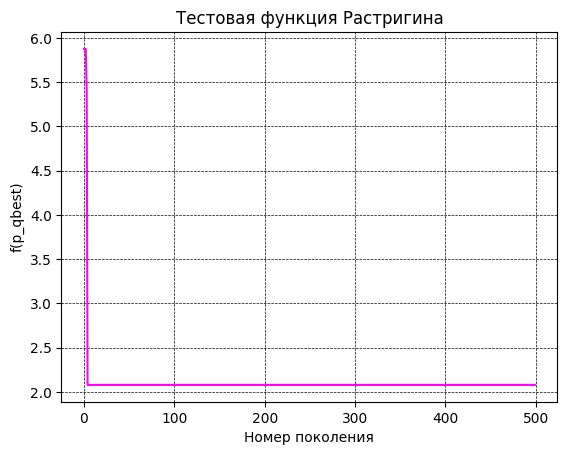

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.05158568 0.09382616]
The function value of pqbest:		2.2201217163206053
Algorithm running time:			1.1059033870697021 s


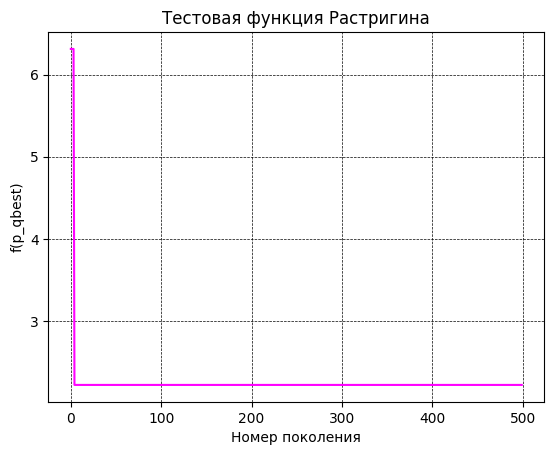

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-1.01881978  0.05929185]
The function value of pqbest:		1.7972887019650656
Algorithm running time:			1.2075071334838867 s


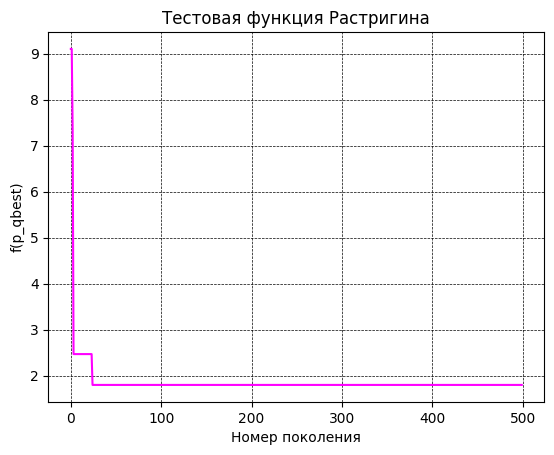

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.07161107 -0.05203278]
The function value of pqbest:		1.5328061713684633
Algorithm running time:			1.1610729694366455 s


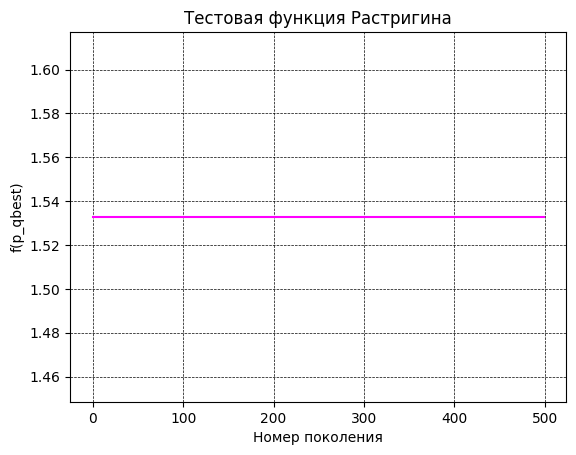

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.92440921 0.00712505]
The function value of pqbest:		1.9714508578174659
Algorithm running time:			1.2148592472076416 s


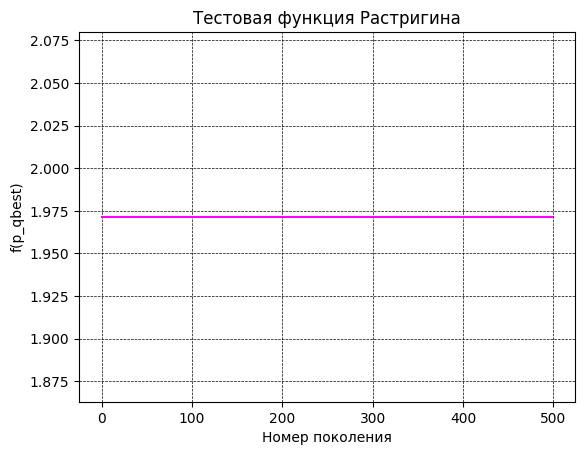

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.93749524  0.03046801]
The function value of pqbest:		1.8238248205168652
Algorithm running time:			1.1767892837524414 s


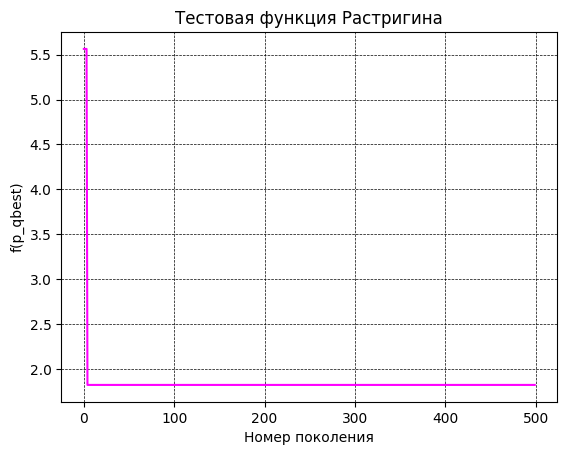

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.99620165 0.97635148]
The function value of pqbest:		2.0587167418753154
Algorithm running time:			1.3138132095336914 s


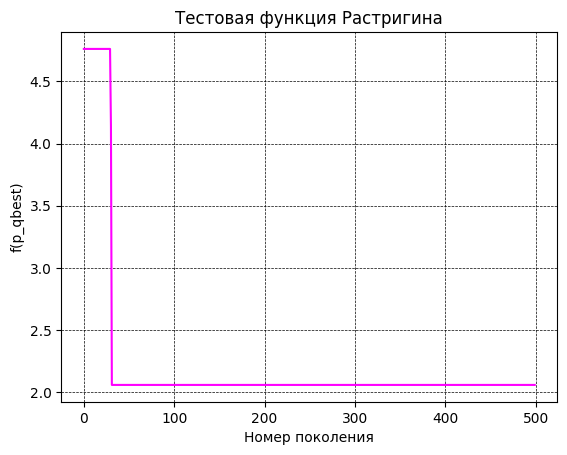

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.92184275 -0.04445365]
The function value of pqbest:		2.4210555571702557
Algorithm running time:			1.2080209255218506 s


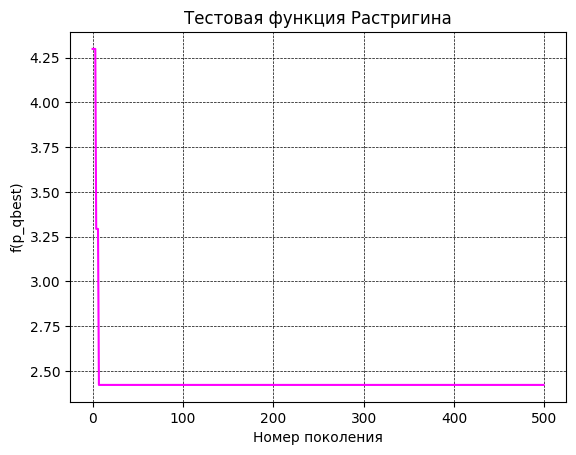

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 1.08259678 -0.09579316]
The function value of pqbest:		4.255200255093655
Algorithm running time:			1.2121517658233643 s


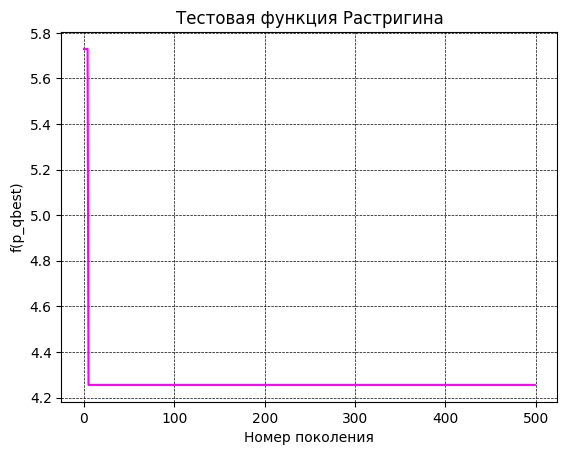

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.0292447  -0.09116922]
The function value of pqbest:		1.7738250191361082
Algorithm running time:			1.1990442276000977 s


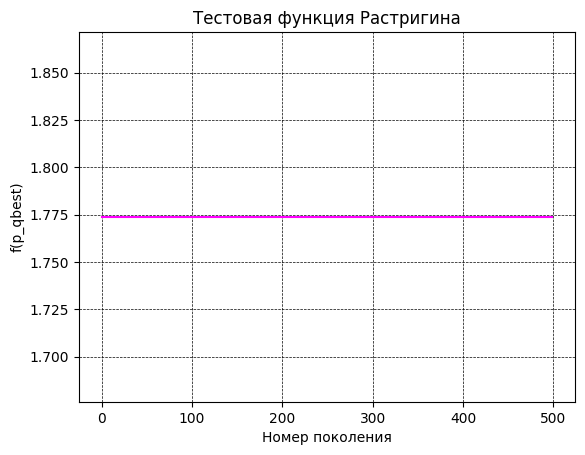

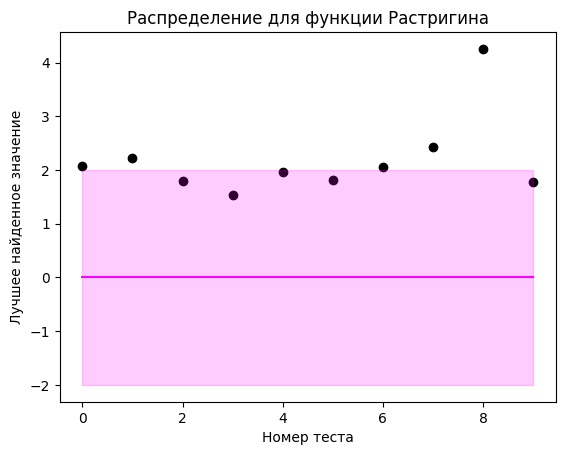

In [711]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [712]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [713]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5, 5, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.10073975  0.10899128]
The function value of pqbest:		0.929400187029767
Algorithm running time:			1.088923692703247 s


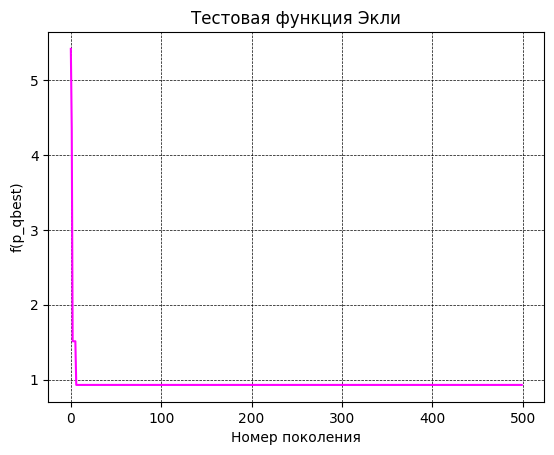

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.00172078 -0.17644146]
The function value of pqbest:		1.1507372030914276
Algorithm running time:			1.0846257209777832 s


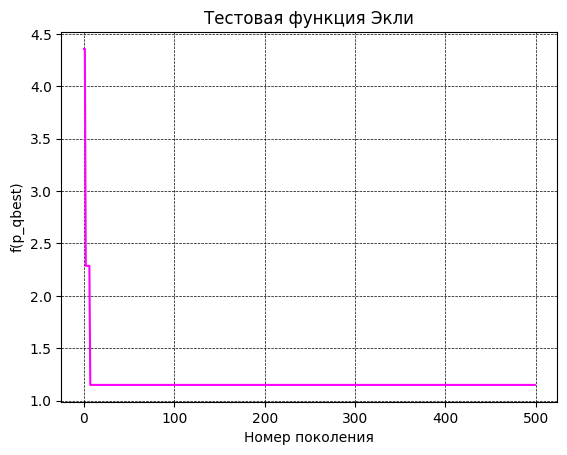

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.00572726 -0.03134854]
The function value of pqbest:		0.11695649237787364
Algorithm running time:			1.0863642692565918 s


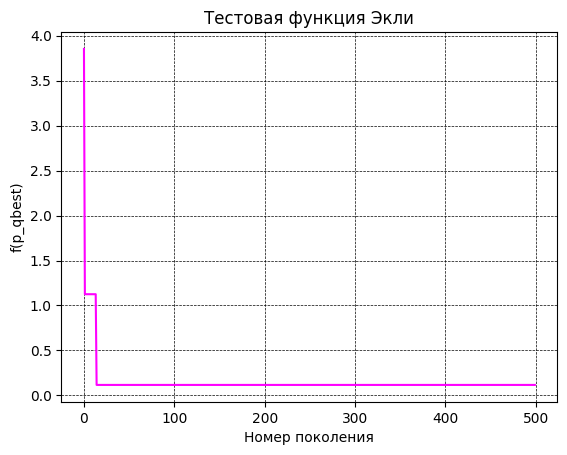

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.06673944 -0.05812056]
The function value of pqbest:		0.448421439530712
Algorithm running time:			1.0831282138824463 s


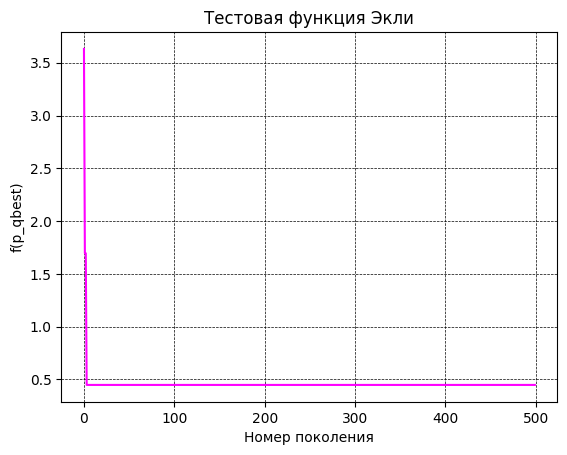

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.27706872 0.02410921]
The function value of pqbest:		1.9833603680575713
Algorithm running time:			1.0958847999572754 s


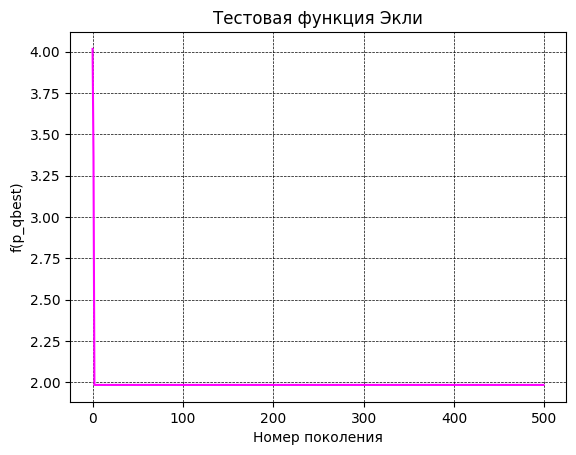

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.01349094 -0.0601275 ]
The function value of pqbest:		0.27241878717545376
Algorithm running time:			1.0763957500457764 s


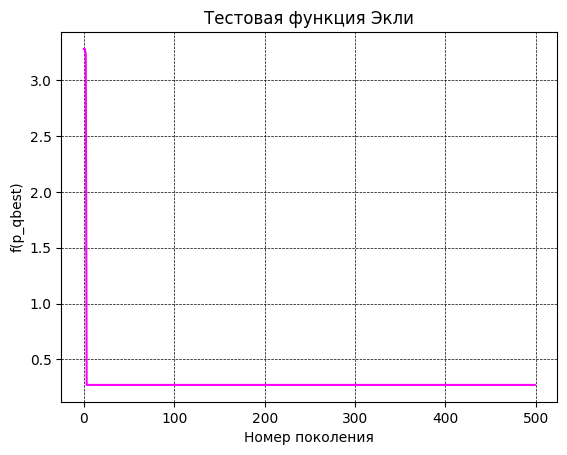

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.07328204 -0.0852256 ]
The function value of pqbest:		0.6277505268661585
Algorithm running time:			1.0963988304138184 s


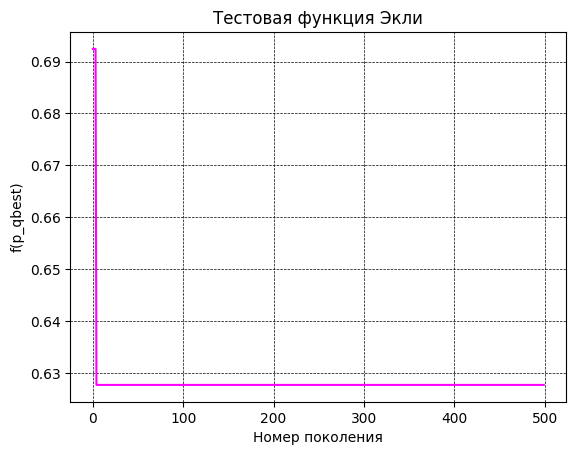

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.16509188 -0.1541046 ]
The function value of pqbest:		1.6350048577768632
Algorithm running time:			1.0751399993896484 s


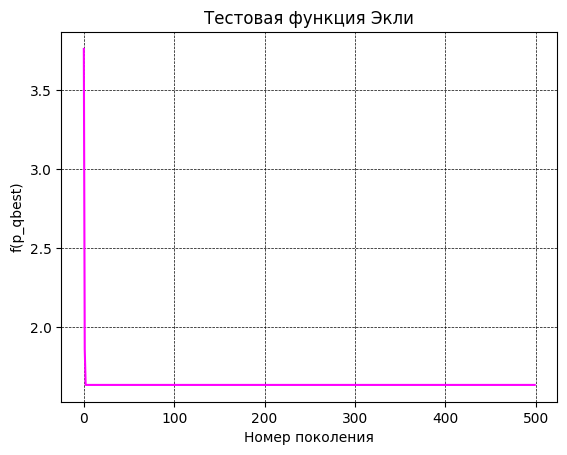

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.16451904 -0.1516574 ]
The function value of pqbest:		1.615805152253504
Algorithm running time:			1.1208877563476562 s


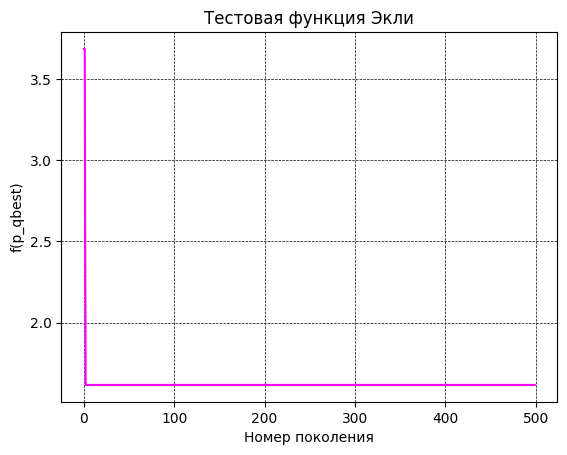

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[0.1439004  0.04337252]
The function value of pqbest:		0.9339014861471888
Algorithm running time:			1.0919053554534912 s


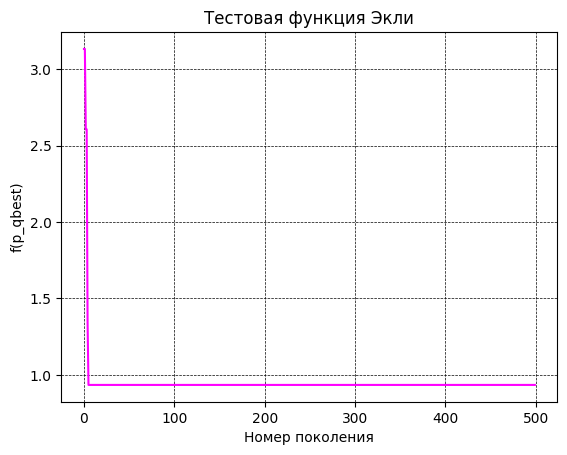

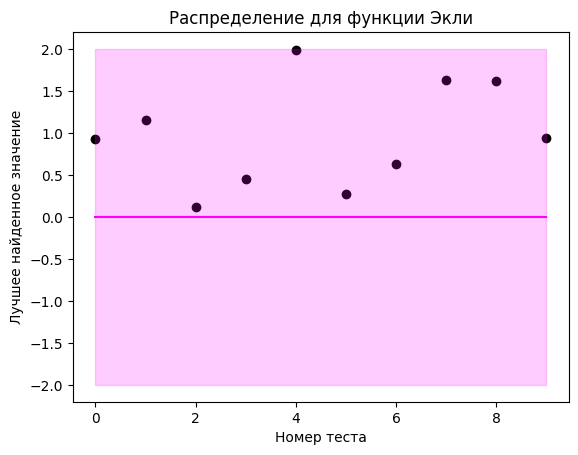

In [714]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [715]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [716]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-10, 10, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.05101371  0.10226049]
The function value of pqbest:		0.013059606986202418
Algorithm running time:			1.0727319717407227 s


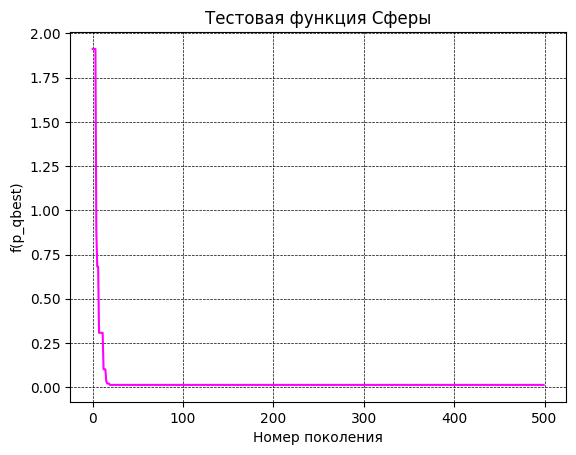

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.09307968  0.0601934 ]
The function value of pqbest:		0.012287072508941541
Algorithm running time:			1.0695652961730957 s


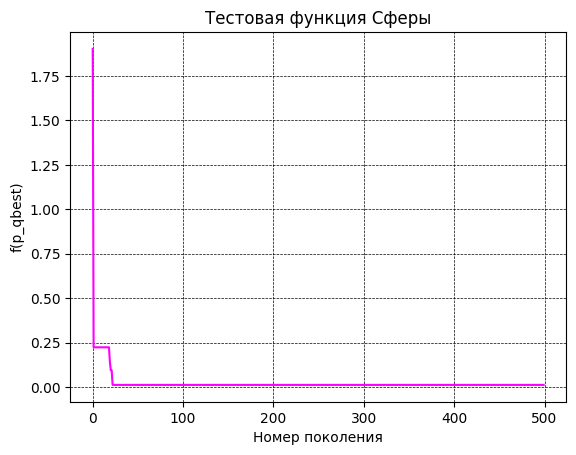

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.11559399 -0.34393419]
The function value of pqbest:		0.13165270184852712
Algorithm running time:			1.082596778869629 s


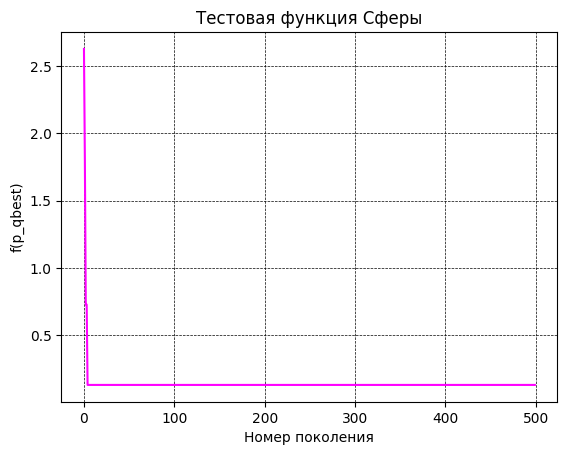

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.24550231 -0.26679739]
The function value of pqbest:		0.13145223352436458
Algorithm running time:			1.136366605758667 s


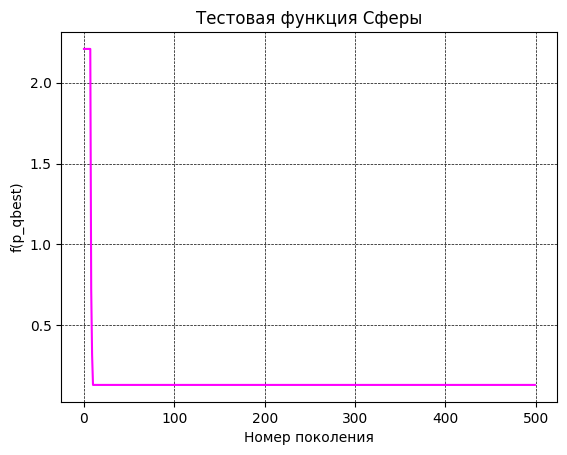

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.04013184 -0.1341479 ]
The function value of pqbest:		0.01960622254386343
Algorithm running time:			1.1053650379180908 s


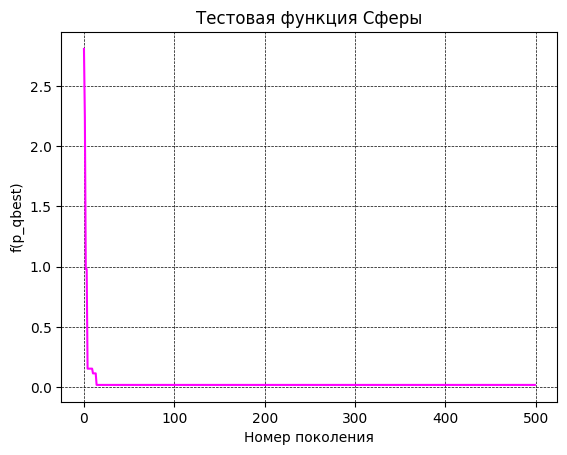

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.1595832  -0.06863786]
The function value of pqbest:		0.030177953625578582
Algorithm running time:			1.1259803771972656 s


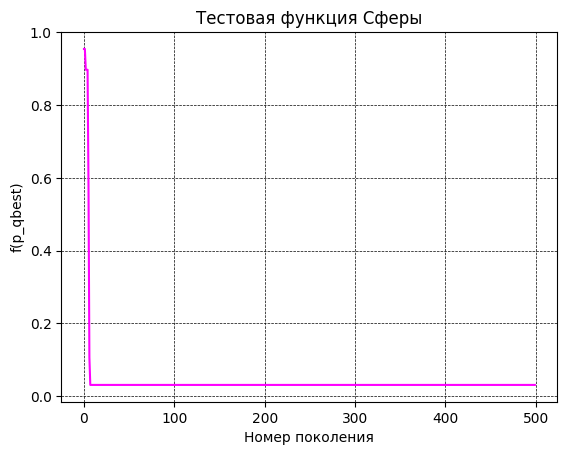

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.01922504 -0.11203833]
The function value of pqbest:		0.012922189464806652
Algorithm running time:			1.053835391998291 s


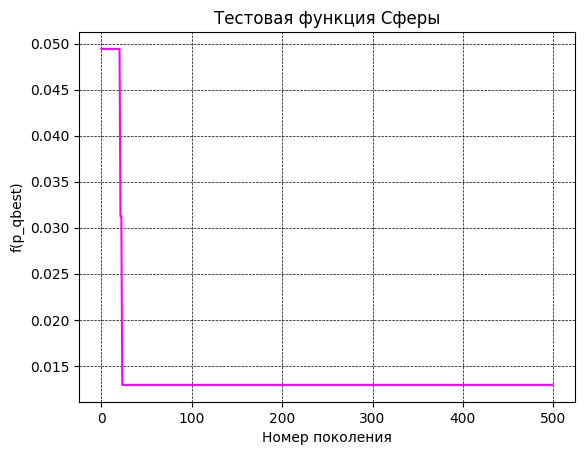

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.02749668 -0.48672053]
The function value of pqbest:		0.2376529448092219
Algorithm running time:			1.1117804050445557 s


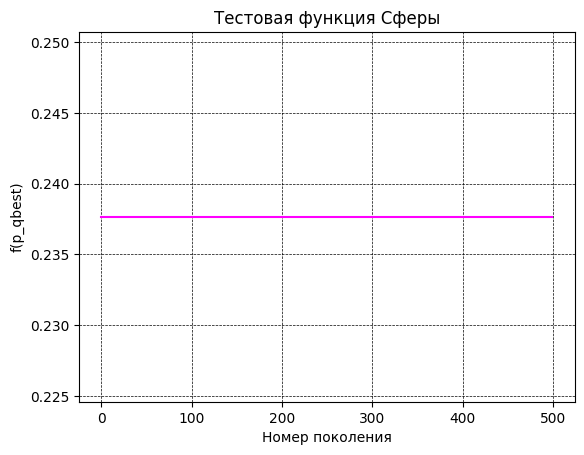

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.10149297 -0.65638521]
The function value of pqbest:		0.4411423685645311
Algorithm running time:			1.1334917545318604 s


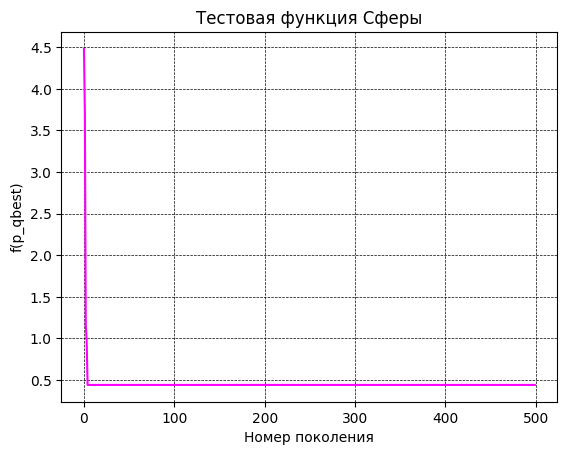

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.21427984  0.07030697]
The function value of pqbest:		0.05085892031745389
Algorithm running time:			1.1309170722961426 s


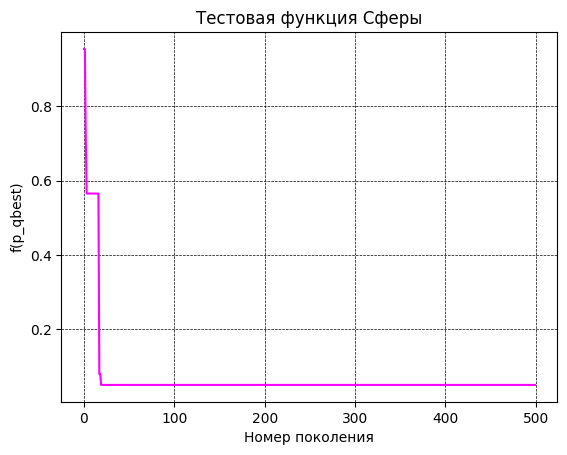

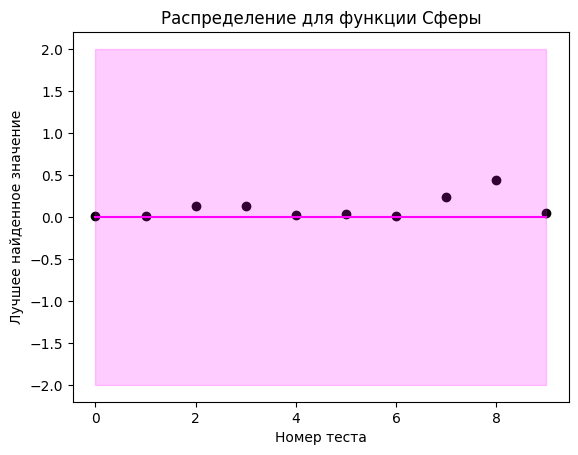

In [717]:
start_test("Сферы")
